- Data tables from [Reid & Brunthaler 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...892...39R/abstract)
- Fiducial coordinates from note in Table 1

In [1]:
import pathlib

import astropy.coordinates as coord
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import yaml

import arviz as az
import pymc3 as pm
import pymc3_ext as pmx
import corner

In [2]:
rng = np.random.default_rng(seed=42)

In [3]:
# See: Table 1 caption in Reid & Brunthaler 2020
fiducial_c = coord.SkyCoord(
    "17:45:40.0409", 
    "-29:00:28.118",
    unit=(u.hourangle, u.degree)
)

The galactic center coordinate in Galactocentric is taken from the Appendix of Reid & Brunthaler 2004. That is from the definition of the origin in Galactic coordinates, propagated to J2000/ICRS frame. In the future, we should use the location of Sgr A* at an epoch. Here we adopt 2016 as the epoch (Gaia DR3).

In [4]:
(fiducial_c.ra.degree,
 fiducial_c.dec.degree)

(266.4168370833333, -29.007810555555555)

In [5]:
(coord.Galactocentric().galcen_coord.ra.degree,
 coord.Galactocentric().galcen_coord.dec.degree)

(266.4051, -28.936175)

In [6]:
diff_sep = fiducial_c.separation(coord.Galactocentric().galcen_coord)
(diff_sep * 8.2*u.kpc).to(u.pc, u.dimensionless_angles())

<Quantity 10.35705401 pc>

---

In [7]:
data_path = pathlib.Path('../data/').resolve()
cache_path = pathlib.Path('../cache/').resolve()
cache_path.mkdir(exist_ok=True)

In [8]:
data = {}
for filename in data_path.glob('J*'):
    name = filename.parts[-1]
    tbl = at.QTable.read(filename, format='ascii.csv')
    tbl['Date'] = Time(tbl['Date'], format='jyear')
    for colname in tbl.colnames[1:]:
        tbl[colname] *= u.mas
    tbl['dEast'] = -tbl['dEast']
    tbl['dNorth'] = -tbl['dNorth']
    data[name] = tbl

0.2 mas 0.6 mas
0.1 mas 0.2 mas


Text(0, 0.5, '$\\Delta\\delta$ [mas]')

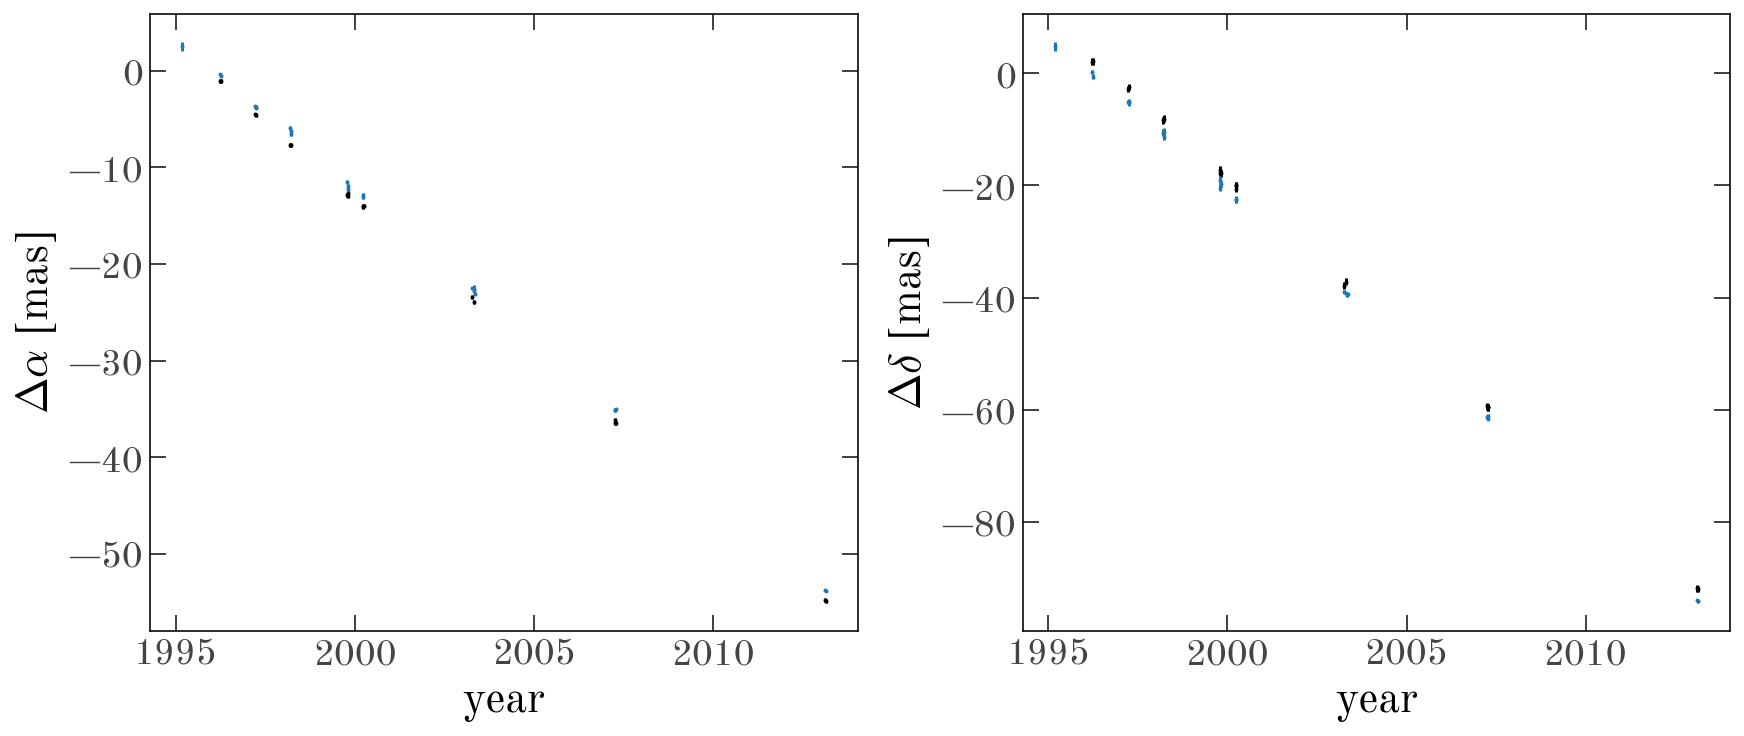

In [9]:
style = dict(ls='none', marker='o', ms=2)

fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 5), 
    sharex=True, 
    constrained_layout=True
)

for name, tbl in data.items():
    print(np.min(tbl['dEast_err']), np.min(tbl['dNorth_err']))
    axes[0].errorbar(
        tbl['Date'].jyear,
        tbl['dEast'].value,
        tbl['dEast_err'].value,
        **style
    )
    
    axes[1].errorbar(
        tbl['Date'].jyear,
        tbl['dNorth'].value,
        tbl['dNorth_err'].value,
        **style
    )

for ax in axes:
    ax.set_xlabel('year')
axes[0].set_ylabel(r'$\Delta\alpha$ [mas]')
axes[1].set_ylabel(r'$\Delta\delta$ [mas]')

In [10]:
EPOCH = 2000.
import theano.tensor as tt

def make_model(t_jyear, dx, dx_err):
    with pm.Model() as model:
        acc = pm.Uniform('acc', -10, 10)  # acceleration in mas/yr**2
        pm_ = pm.Uniform('pm', -10, 10)  # proper motion in mas/yr
        x0 = pm.Uniform('x0', -1000, 1000)
        logs = pm.Uniform('logs', -12, 2)
        s = tt.exp(logs)
        err = tt.sqrt(s**2 + dx_err**2)
        true_dx = acc * (t_jyear - EPOCH)**2 + pm_ * (t_jyear - EPOCH) + x0
        pm.Normal('like', true_dx, err, observed=dx)
    
    return model


def make_joint_model(t_jyear, dx, dx_err, ids):
    with pm.Model() as model:
        acc = pm.Uniform('acc', -10, 10)  # acceleration in mas/yr**2
        pm_ = pm.Uniform('pm', -10, 10)  # proper motion in mas/yr
        
        for id_ in np.unique(ids):
            mask = ids == id_
            x = t_jyear[mask]
            y = dx[mask]
            y_err = dx_err[mask]

            x0 = pm.Uniform(f'x0_{id_}', -1000, 1000)
            logs = pm.Uniform(f'logs_{id_}', -12, 2)
            s = tt.exp(logs)
            err = tt.sqrt(s**2 + y_err**2)
            true_dx = acc * (x - EPOCH)**2 + pm_ * (x - EPOCH) + x0
            pm.Normal(f'like_{id_}', true_dx, err, observed=y)
    
    return model

In [11]:
all_samples = {}
for name, tbl in data.items():
    for dir_ in ['East', 'North']:
        seed = int(rng.integers(0, 100_000))
        with make_model(tbl['Date'].jyear, tbl[f'd{dir_}'].value, tbl[f'd{dir_}_err'].value) as model:
            res = pmx.optimize(start={'pm': -3, 'x0': 0})
            print(res)
            all_samples[name + dir_] = pmx.sample(tune=1000, draws=10000, chains=2,
                                                  start=res, return_inferencedata=True,
                                                  random_seed=seed)

optimizing logp for variables: [logs, x0, pm, acc]


message: Optimization terminated successfully.
logp: -44122.486553969706 -> 2.512363600201981



{'acc_interval__': array(0.00058358), 'pm_interval__': array(-0.66163001), 'x0_interval__': array(-0.02662843), 'logs_interval__': array(-0.05068897), 'acc': array(0.00291792), 'pm': array(-3.19252907), 'x0': array(-13.31342708), 'logs': array(-5.17737343)}


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs, x0, pm, acc]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
optimizing logp for variables: [logs, x0, pm, acc]


message: Optimization terminated successfully.
logp: -19784.455479257296 -> -17.253662630734823



{'acc_interval__': array(0.00127923), 'pm_interval__': array(-1.28403004), 'x0_interval__': array(-0.03749419), 'logs_interval__': array(-0.00978178), 'acc': array(0.00639616), 'pm': array(-5.66269994), 'x0': array(-18.74490033), 'logs': array(-5.03423596)}


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs, x0, pm, acc]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
optimizing logp for variables: [logs, x0, pm, acc]


message: Desired error not necessarily achieved due to precision loss.
logp: -110431.85327200785 -> -6.060645716862849



{'acc_interval__': array(-0.0002534), 'pm_interval__': array(-0.64949304), 'x0_interval__': array(-0.02459618), 'logs_interval__': array(0.9426742), 'acc': array(-0.00126698), 'pm': array(-3.13792422), 'x0': array(-12.2974715), 'logs': array(-1.92504678)}


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs, x0, pm, acc]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
The number of effective samples is smaller than 10% for some parameters.
optimizing logp for variables: [logs, x0, pm, acc]


message: Optimization terminated successfully.
logp: -159903.7600486351 -> -12.75757385243227



{'acc_interval__': array(-0.00050046), 'pm_interval__': array(-1.25156558), 'x0_interval__': array(-0.0416311), 'logs_interval__': array(-0.02760475), 'acc': array(-0.0025023), 'pm': array(-5.55141506), 'x0': array(-20.81254563), 'logs': array(-5.09661048)}


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs, x0, pm, acc]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.


In [12]:
# Joint fit:
tbl = at.vstack((data['J1745-283'], data['J1748-291']))
tbl['id'] = np.ones(len(tbl), dtype=int)
tbl['id'][len(data['J1745-283']):] = 2

for dir_ in ['East', 'North']:
    seed = int(rng.integers(0, 100_000))
    with make_joint_model(tbl['Date'].jyear, tbl[f'd{dir_}'].value, tbl[f'd{dir_}_err'].value, tbl['id']) as model:
        res = pmx.optimize(start={'pm': -3, 'x0': 0})
        print(res)
        all_samples['joint' + dir_] = pmx.sample(
            tune=1000, draws=10000, chains=2,
            start=res, return_inferencedata=True,
            random_seed=seed
        )

optimizing logp for variables: [logs_2, x0_2, logs_1, x0_1, pm, acc]



{'acc_interval__': array(0.00013437), 'pm_interval__': array(-0.65520472), 'x0_1_interval__': array(-0.02461042), 'logs_1_interval__': array(1.0020683), 'x0_2_interval__': array(-0.02660827), 'logs_2_interval__': array(-0.03985052), 'acc': array(0.00067185), 'pm': array(-3.16364747), 'x0_1': array(-12.3045911), 'logs_1': array(-1.75948949), 'x0_2': array(-13.3033477), 'logs_2': array(-5.13945835)}


message: Desired error not necessarily achieved due to precision loss.
logp: -154551.47292657584 -> -3.127895773287711
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs_2, x0_2, logs_1, x0_1, pm, acc]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
optimizing logp for variables: [logs_2, x0_2, logs_1, x0_1, pm, acc]


message: Optimization terminated successfully.
logp: -179685.3486284907 -> -28.48395474032806



{'acc_interval__': array(-0.00020291), 'pm_interval__': array(-1.25768211), 'x0_1_interval__': array(-0.04157495), 'logs_1_interval__': array(-0.0266951), 'x0_2_interval__': array(-0.03740707), 'logs_2_interval__': array(-0.00771995), 'acc': array(-0.00101456), 'pm': array(-5.57253677), 'x0_1': array(-20.78447891), 'logs_1': array(-5.09342731), 'x0_2': array(-18.70135528), 'logs_2': array(-5.02701969)}


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs_2, x0_2, logs_1, x0_1, pm, acc]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [13]:
pm.summary(all_samples['jointEast'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acc,0.001,0.001,-0.002,0.003,0.000,0.000,13255.0,12440.0,1.0
pm,-3.165,0.015,-3.192,-3.138,0.000,0.000,10331.0,12070.0,1.0
x0_1,-12.305,0.058,-12.413,-12.194,0.001,0.000,12125.0,10125.0,1.0
logs_1,-1.738,0.561,-2.382,-1.074,0.022,0.018,5353.0,2631.0,1.0
x0_2,-13.304,0.051,-13.403,-13.209,0.000,0.000,13331.0,12583.0,1.0
logs_2,-7.153,2.806,-11.970,-2.848,0.028,0.022,9276.0,7510.0,1.0


In [14]:
pm.summary(all_samples['jointNorth'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acc,-0.001,0.002,-0.005,0.003,0.000,0.000,11130.0,10226.0,1.0
pm,-5.573,0.025,-5.619,-5.526,0.000,0.000,8701.0,2343.0,1.0
x0_1,-20.787,0.088,-20.958,-20.628,0.001,0.001,8435.0,2345.0,1.0
logs_1,-6.936,2.955,-11.956,-2.393,0.037,0.026,3948.0,2249.0,1.0
x0_2,-18.699,0.141,-18.959,-18.433,0.001,0.001,11094.0,7619.0,1.0
logs_2,-6.640,3.051,-11.950,-1.931,0.031,0.024,9207.0,7386.0,1.0


In [15]:
pm_east = np.mean(all_samples['jointEast'].posterior.pm.values.ravel())
pm_east_err = np.std(all_samples['jointEast'].posterior.pm.values.ravel())

pm_north = np.mean(all_samples['jointNorth'].posterior.pm.values.ravel())
pm_north_err = np.std(all_samples['jointNorth'].posterior.pm.values.ravel())

In [16]:
m = np.stack((all_samples['jointEast'].posterior.pm.values.ravel(),
              all_samples['jointNorth'].posterior.pm.values.ravel()))
np.cov(m)

array([[2.13986766e-04, 1.20303416e-06],
       [1.20303416e-06, 6.13339418e-04]])

In [17]:
print(f"pm_E = {pm_east:.3f} +/- {pm_east_err:.3f}")
print(f"pm_N = {pm_north:.3f} +/- {pm_north_err:.3f}")

pm_E = -3.165 +/- 0.015
pm_N = -5.573 +/- 0.025


In [18]:
pos_east_2016 = all_samples['jointEast'].posterior.pm * (2016 - EPOCH) + all_samples['jointEast'].posterior.x0_1
pos_north_2016 = all_samples['jointNorth'].posterior.pm * (2016 - EPOCH) + all_samples['jointNorth'].posterior.x0_1

In [19]:
np.mean(pos_east_2016).values, np.mean(pos_north_2016).values

(array(-62.94208387), array(-109.95160969))

In [20]:
np.std(pos_east_2016).values, np.std(pos_north_2016).values

(array(0.24969192), array(0.3839805))

In [21]:
sgr_ra_2016 = fiducial_c.ra + np.mean(pos_east_2016).values * u.mas
sgr_dec_2016 = fiducial_c.dec + np.mean(pos_north_2016).values * u.mas

In [22]:
Rsun = 8.275 * u.kpc
cc = coord.SkyCoord(
    sgr_ra_2016, 
    sgr_dec_2016,
    distance=Rsun,
    pm_ra_cosdec=pm_east * u.mas/u.yr,
    pm_dec=pm_north * u.mas/u.yr,
    radial_velocity=0*u.km/u.s
)

galcen_frame = coord.Galactocentric(
    galcen_v_sun=[0, 0, 0]*u.km/u.s,
    galcen_distance=Rsun,
    z_sun=20.8 * u.pc,
    galcen_coord=coord.SkyCoord(sgr_ra_2016, sgr_dec_2016)
)

In [23]:
-cc.transform_to(galcen_frame).velocity.d_xyz

<Quantity [1.99484937e-02, 2.51272397e+02, 7.93621461e+00] km / s>

In [24]:
all_samples.keys()

dict_keys(['J1748-291East', 'J1748-291North', 'J1745-283East', 'J1745-283North', 'jointEast', 'jointNorth'])

In [25]:
colors = ['tab:blue', 'tab:orange', 'k']

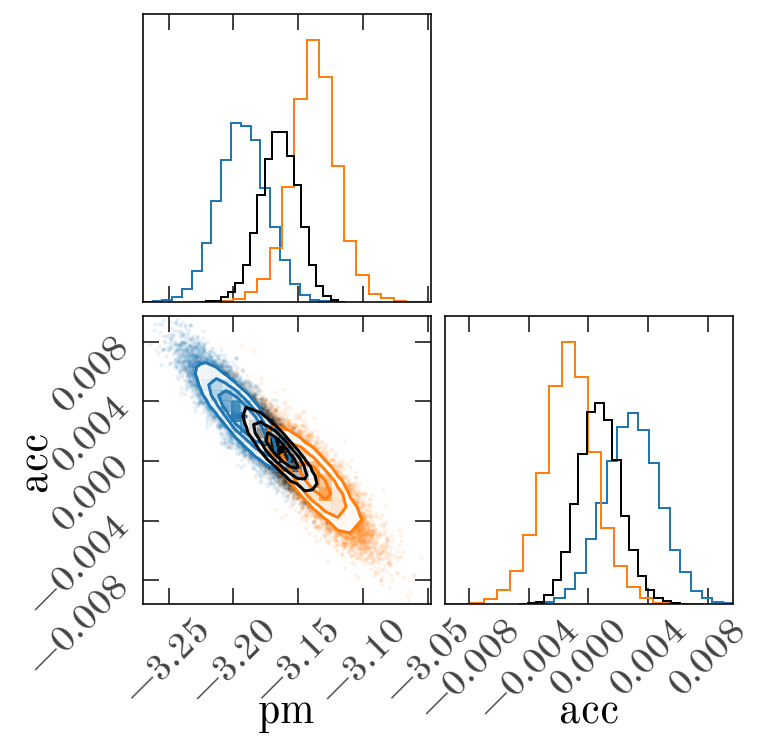

In [26]:
fig = None
for name, color in zip(['J1748-291East', 'J1745-283East', 'jointEast'],
                       colors):
    if fig is None:
        fig = corner.corner(all_samples[name].posterior, color=color, 
                            var_names=['pm', 'acc'])
    else:
        fig = corner.corner(all_samples[name].posterior, fig=fig, color=color,
                            var_names=['pm', 'acc'])

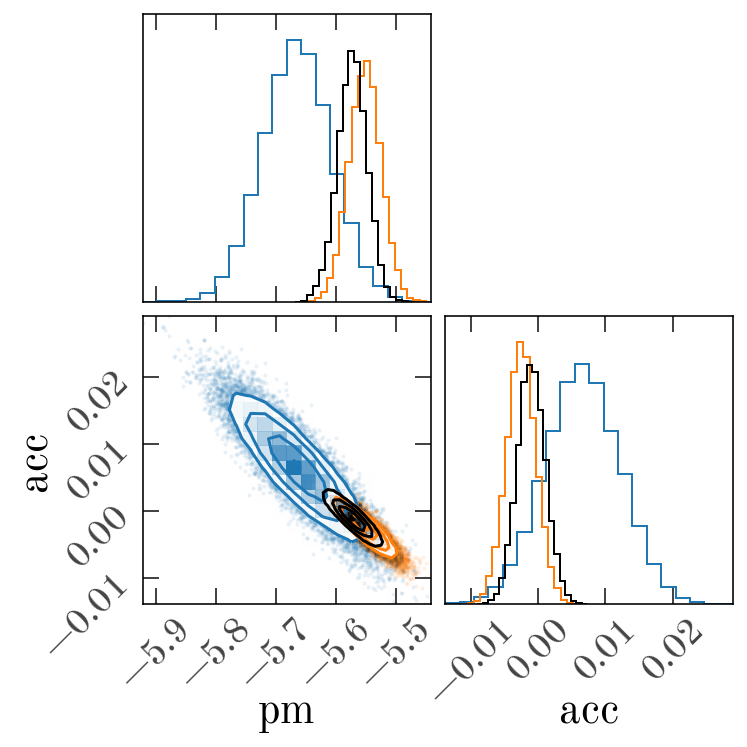

In [27]:
fig = None
for name, color in zip(['J1748-291North', 'J1745-283North', 'jointNorth'],
                       colors):
    if fig is None:
        fig = corner.corner(all_samples[name].posterior, color=color, 
                            var_names=['pm', 'acc'])
    else:
        fig = corner.corner(all_samples[name].posterior, fig=fig, color=color,
                            var_names=['pm', 'acc'])

In [28]:
results = {
    'epoch': 2016,
    'ra': sgr_ra_2016,
    'ra_err': np.std(pos_east_2016).values * u.mas,
    'dec': sgr_dec_2016,
    'dec_err': np.std(pos_north_2016).values * u.mas, 
    'pmra': pm_east * u.mas/u.yr,
    'pmra_err': pm_east_err * u.mas/u.yr,
    'pmdec': pm_north * u.mas/u.yr,
    'pmdec_err': pm_north_err * u.mas/u.yr,
}
results = at.QTable([results])
results.write(cache_path / 'Reid2020_refit.ecsv',
              overwrite=True)
results

epoch,ra,ra_err,dec,dec_err,pmra,pmra_err,pmdec,pmdec_err
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr
int64,float64,float64,float64,float64,float64,float64,float64,float64
2016,266.4168195994211,0.24969192390850387,-29.007841097669356,0.383980501844335,-3.164792892038991,0.014627920774372697,-5.572780423509764,0.024765071183629438
